# Seventh Session, Notebook # 12: Introduction to Statistics and MCMC

## Today's agenda:
0. __Workshop Overview__:
    * __When__: August 22nd  1pm-5pm<!---*insert day* from *insert time range*--->
    * __Where__: CUNY Graduate Center <!---*insert room number--->
    * __What__: Today we will be learning about statistics and MCMC!
    * __Want__ to lead a session for a topic? Some Days there will be small hack sessions for people to discuss problems they're working on.
    * __Online Resources__:  __https://daxfeliz.github.io/cunybridgebootcamp/__
    * __Program Schedule__: __https://tinyurl.com/4r35txe2__   
&nbsp;

1. __This session__:
* Learning about statistics and applying them to real data
* Learning about MCMC and how to find optimized solutions for model fitting

</br>
&nbsp;

2. __Next session__:
    * Introduction to Gaussian Processes! __Make sure you bring your laptop to this session and future sessions__.


In [91]:
# Let's import some modules that we'll use today:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats

# One of the data sets we'll work with comes from the ESA Hipparcos satellite. 

## ESA's Hipparcos space astrometry mission was a pioneering European project which pinpointed the positions of more than one hundred thousand stars with high precision


Let's read in our data set, called 'hipparchos_subsample.dat', and create a histogram of our measured distances for stars within 1,000 parsecs

Data Points per bin:
[ 86. 328. 526. 602. 613. 625. 640. 606. 573. 473. 429. 453. 441. 366.
 347. 282. 270. 253. 189. 186. 155. 141. 146. 106.  98. 114.  77.  80.
  67.  70.  65.  61.  55.  39.  46.  42.  35.  33.  34.  29.  42.  18.
  30.  21.  16.  27.  14.  17.  15.  17.]
Data Points per bin (sorted):
[ 14.  15.  16.  17.  17.  18.  21.  27.  29.  30.  33.  34.  35.  39.
  42.  42.  46.  55.  61.  65.  67.  70.  77.  80.  86.  98. 106. 114.
 141. 146. 155. 186. 189. 253. 270. 282. 328. 347. 366. 429. 441. 453.
 473. 526. 573. 602. 606. 613. 625. 640.]


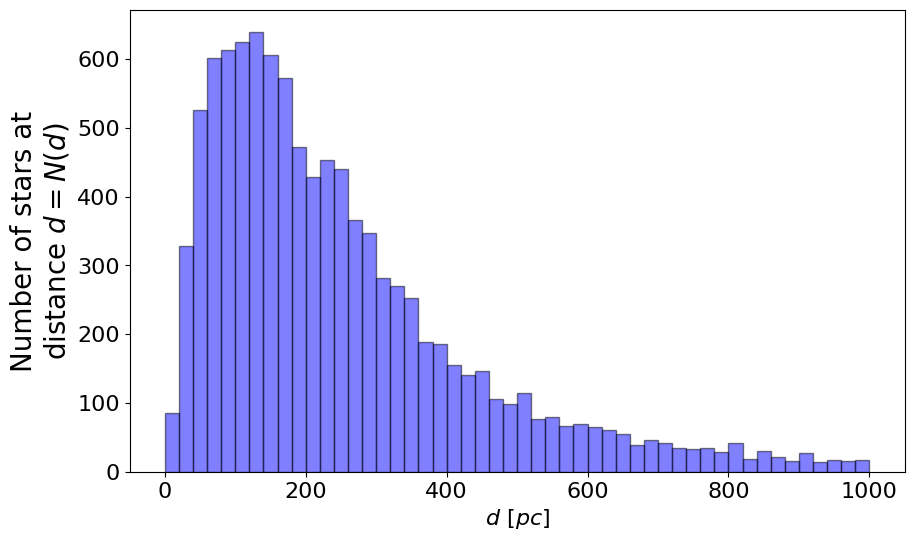

In [92]:
Data = np.loadtxt( 'hipparcos_subsample.dat' )
nDataPoints = len( Data )

xMin = 0
xMax = 1000
nBins = 50

fs=16
fig = plt.figure( figsize = ( 10, 6 ) )

DataPointsPerBin, BinEdges, patches = plt.hist( Data, histtype = 'bar',\
                                                bins = nBins, range = ( xMin, xMax ) , 
                                               color='blue', ec='black',alpha=0.5)

print( 'Data Points per bin:')
print (DataPointsPerBin)

print ('Data Points per bin (sorted):')
print (np.sort( DataPointsPerBin ))

plt.xlabel( '$d\ [pc]$', fontsize = fs )
plt.ylabel( 'Number of stars at\n'+r'distance $d=N\left(d\right)$', fontsize = 20 )
plt.xticks( fontsize = fs )
plt.yticks( fontsize = fs )

plt.show()


The data at small $d$ increases like $d^2$ because our bins (spherical annuli) have volumes that increase like $d^2$ ($dV=4\pi r^2dr$), so we will have more stars in bins with larger volumes. The data at large $d$ decreases because our sample is flux-limited, i.e. we can't see all of the fainter stars at large distances.


## We can see that on the vertical axis, we have counts of distance measurements per bin of parsecs.

## If we wanted to convert this vertical axis to better show the proportion of the data in each bin, we can normalize our histogram by dividing by the number of distance measurements in our data set.

## Probabilities are defined between 0 and 1, so for our plot to be interpreted as a probability we have to normalize it.

Bins (raw):
 [  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360. 370. 380. 390. 400. 410.
 420. 430. 440. 450. 460. 470. 480. 490. 500. 510. 520. 530. 540. 550.
 560. 570. 580. 590. 600. 610. 620. 630. 640. 650. 660. 670. 680. 690.
 700. 710. 720. 730. 740. 750. 760. 770. 780. 790. 800. 810. 820. 830.
 840. 850. 860. 870. 880. 890. 900. 910. 920. 930. 940. 950. 960. 970.
 980. 990.]
Bins (shifted):
 [  5.  15.  25.  35.  45.  55.  65.  75.  85.  95. 105. 115. 125. 135.
 145. 155. 165. 175. 185. 195. 205. 215. 225. 235. 245. 255. 265. 275.
 285. 295. 305. 315. 325. 335. 345. 355. 365. 375. 385. 395. 405. 415.
 425. 435. 445. 455. 465. 475. 485. 495. 505. 515. 525. 535. 545. 555.
 565. 575. 585. 595. 605. 615. 625. 635. 645. 655. 665. 675. 685. 695.
 705. 715. 725. 735. 745. 755. 765. 775. 785. 795. 805. 815. 825. 835.
 845. 855. 865. 875. 885. 895. 905.

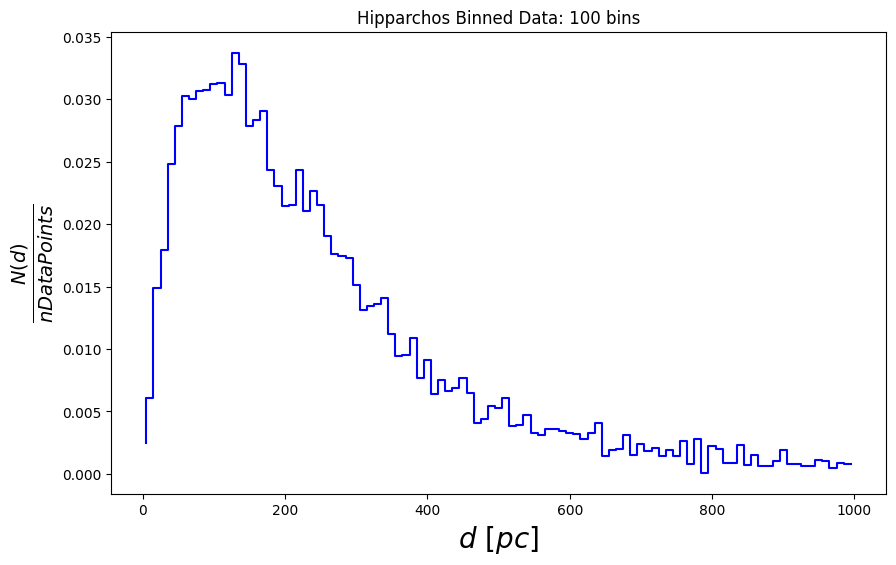

In [93]:
#Manually creating Bins

nBinEdges = 101
xMin = 0
xMax = 1000
BinEdges0                = np.linspace( xMin, xMax, nBinEdges )
counts0, edges0 = np.histogram( Data, bins = BinEdges0 )

nBins = nBinEdges - 1

BinWidth0 = ( xMax - xMin ) / nBins

bins0 = np.copy( BinEdges0[ 0 : -1 ] ) # Remove one element (the last bin edge)\
                                     # because there is always one less bin than bin edges

bins0 += BinWidth0 / 2                 # We want our bins to be centered on their central x-values
# i.e if we have a bin that starts at 0 pc and goes to 10 pc and we want it centered at 5 pc

# Equivalently
#Bins = np.copy( BinEdges[ 1 :  ] )
#Bins -= BinWidth / 2

datalength = len(Data)*1.0
counts = counts0/datalength



print ('Bins (raw):\n', BinEdges0[ 0 : -1 ])
print ('Bins (shifted):\n', bins0)
print(' ')


print ("hipparchos counts:", counts0)
print(' ')
plt.figure( figsize = ( 10, 6 ) )
plt.step(bins0, counts, color='blue')
plt.title('Hipparchos Binned Data: 100 bins')
plt.xlabel( '$d~[pc]$', fontsize = 20 )
plt.ylabel( r'$\frac{N\left(d\right)}{nDataPoints}$', fontsize = 20 )

plt.show()


# if we try with a smaller number of bins (let's try 50), we'll have larger bin widths as a result

hipparchos counts: [ 86 328 526 602 613 625 640 606 573 473 429 453 441 366 347 282 270 253
 189 186 155 141 146 106  98 114  77  80  67  70  65  61  55  39  46  42
  35  33  34  29  42  18  30  21  16  27  14  17  15  17]
 
bins: [ 10.  30.  50.  70.  90. 110. 130. 150. 170. 190. 210. 230. 250. 270.
 290. 310. 330. 350. 370. 390. 410. 430. 450. 470. 490. 510. 530. 550.
 570. 590. 610. 630. 650. 670. 690. 710. 730. 750. 770. 790. 810. 830.
 850. 870. 890. 910. 930. 950. 970. 990.]
 


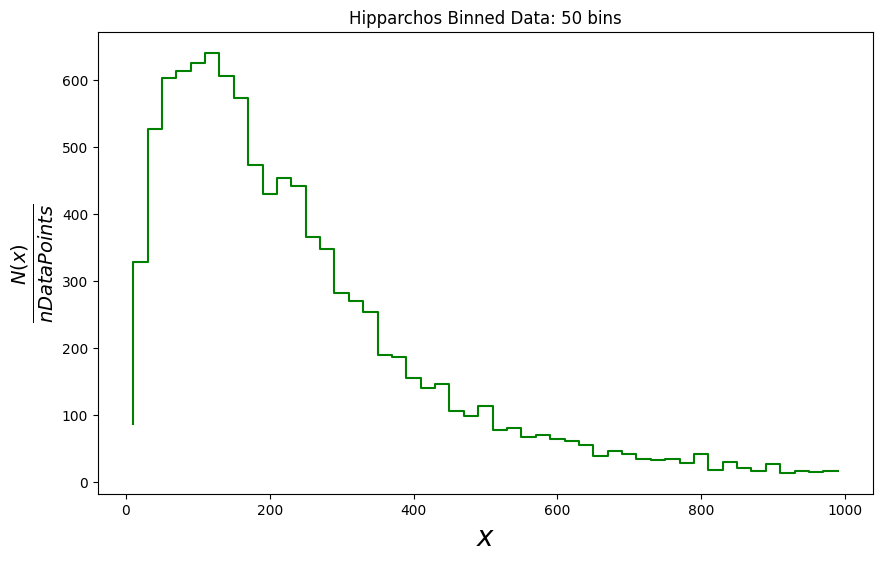

In [94]:



nBinEdges = 51
BinEdges                = np.linspace( xMin, xMax, nBinEdges )
countsfifty, edgesfifty = np.histogram( Data, bins = BinEdges )

nBins = nBinEdges - 1

BinWidth = ( xMax - xMin ) / nBins

binsfifty  = np.copy( BinEdges[ 0 : -1 ] ) # Remove one element (the last bin edge)\
                                     # because there is always one less bin than bin edges

binsfifty += BinWidth / 2                 # We want our bins to be centered on their central x-values
# i.e if we have a bin that starts at 0 pc and goes to 10 pc and we want it centered at 5 pc


datalength = len(Data)*1.0
counts = countsfifty/datalength
# print(bins);print('');print( counts)

print ("hipparchos counts:", countsfifty)
print(' ')
print ("bins:", binsfifty)
print(' ')
plt.figure( figsize = ( 10, 6 ) )
plt.step(binsfifty, countsfifty, color='green')
plt.title('Hipparchos Binned Data: 50 bins')
plt.xlabel( '$x$', fontsize = 20 )
plt.ylabel( r'$\frac{N\left(x\right)}{nDataPoints}$', fontsize = 20 )
plt.show()


# the way we can calculate our bin with is by taking the range(max-min) and dividing by the number of bins

In [95]:
bin_width100 = (np.max(bins0)-np.min(bins0))/len(bins0)
bin_width50 = (np.max(binsfifty)-np.min(binsfifty))/len(binsfifty)
print('bin widths:',bin_width50,bin_width100)


bin widths: 19.6 9.9


We want to have a histogram that is independent of our binning. To do this we plot not $N/nDataPoints$, but $N/\left(nDataPoints\times\text{BinWidth}\right)$ (i.e. $N/\left(nDataPoints\times dx\right)$). This is because if BinWidth doubles, so does $N$. i.e. if the bin is twice as big it will also have twice as many stars. This is an approximation for small bin widths. Note that this changes the dimensions of the vertical axis from being dimensionless to being $\text{BinWidth}^{-1}$ (i.e. $x^{-1}$)

## "Normalized" Histogram with Different Bin Widths

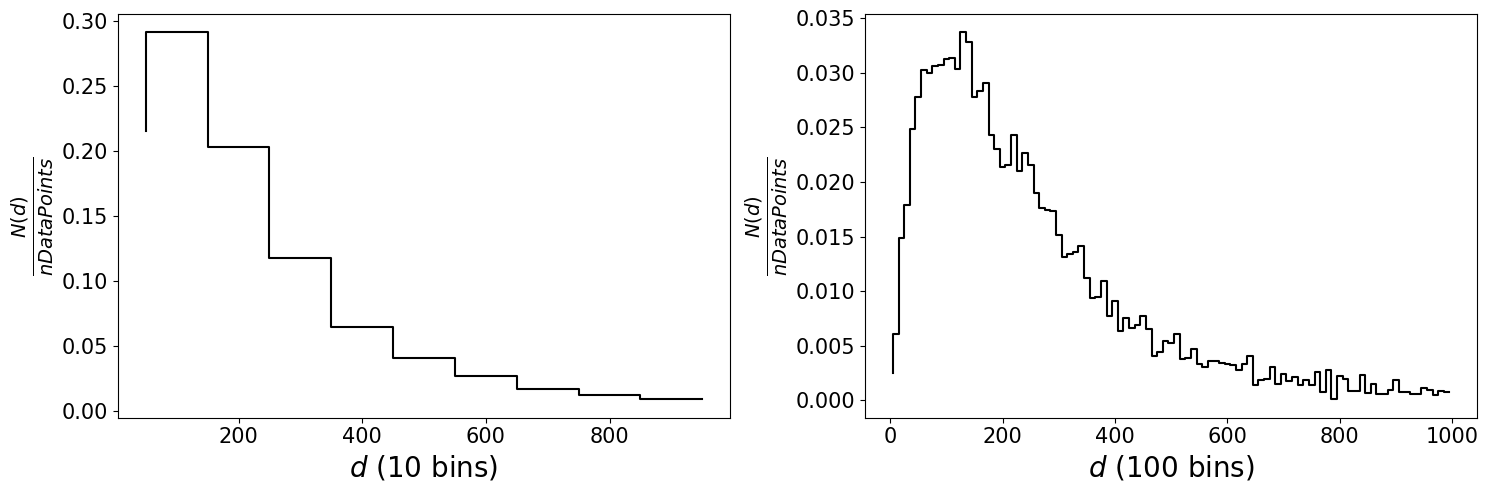

In [96]:
fig = plt.figure( figsize = ( 15, 5 ) )
xMin = 0
xMax = 1000

def NormHist( nBinEdges, Data, xMin, xMax, PlotNumber ):
    
    BinEdges                = np.linspace( xMin, xMax, nBinEdges )
    DataPointsPerBin, edges = np.histogram( Data, bins = BinEdges )
    
    nBins = nBinEdges - 1
    BinWidth = ( xMax - xMin ) / nBins
    
    Bins = BinEdges[ 0 : -1 ] + BinWidth / 2
    DataPointsPerBinNormalized = DataPointsPerBin / len( Data )
    
    plt.subplot( 1, 2, PlotNumber )
    
    plt.step( Bins, DataPointsPerBinNormalized, c = 'k' )

    plt.xlabel( '$d$ (' + str( nBins ) + ' bins)', fontsize = 20 )
    plt.ylabel( r'$\frac{N\left(d\right)}{nDataPoints}$', fontsize = 20 )
    plt.xticks( fontsize = 15 )
    plt.yticks( fontsize = 15 )
    
    return Bins, DataPointsPerBinNormalized

Bins10, DataPointsPerBinNormalized10 = NormHist( nBinEdges = 10+1, Data = Data, xMin = xMin, xMax = xMax, PlotNumber = 1 )
Bins100, DataPointsPerBinNormalized100 = NormHist( nBinEdges = 100+1, Data = Data, xMin = xMin, xMax = xMax, PlotNumber = 2 )
plt.tight_layout(pad=1)
plt.show()


# Note: that the values on the vertical axis are different for the two distributions. This is because we didn't divide by the bin width.


## Properly (Bin Width independently) Normalized Histogram

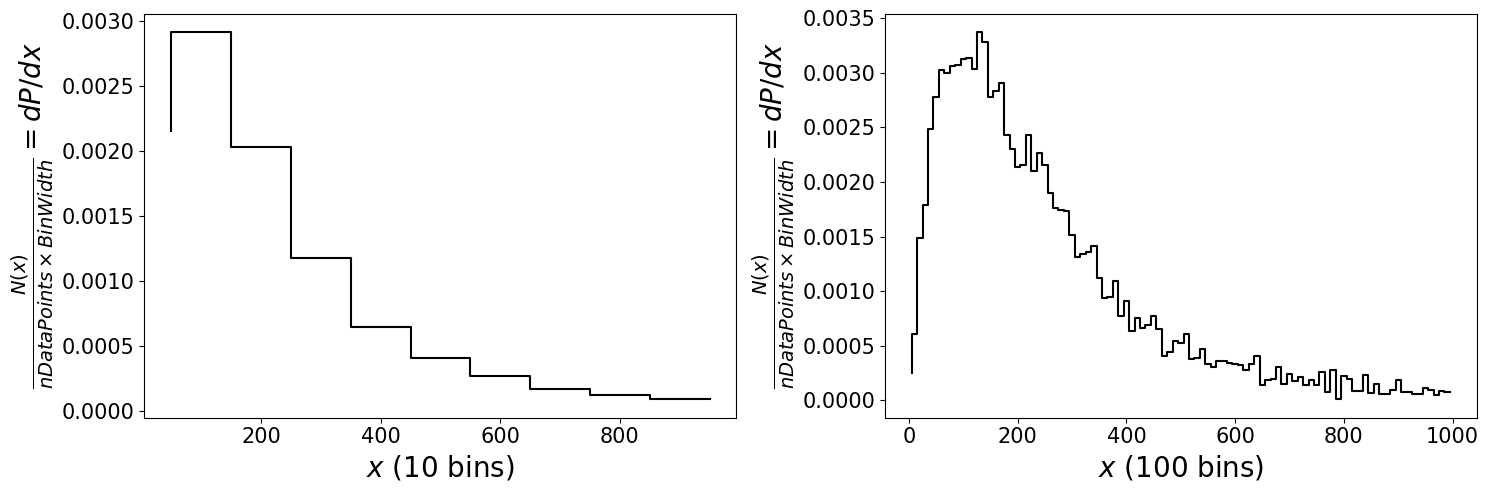

In [97]:
fig = plt.figure( figsize = ( 15, 5 ) )

def PropNormHist( nBinEdges, Data, xMin, xMax, PlotNumber ):
        
    BinEdges                = np.linspace( xMin, xMax, nBinEdges )
    DataPointsPerBin, edges = np.histogram( Data, bins = BinEdges )
    
    nBins = nBinEdges - 1
    BinWidth = ( xMax - xMin ) / nBins
    
    Bins = BinEdges[ 0 : -1 ] + BinWidth / 2
    DataPointsPerBinNormalized = DataPointsPerBin / ( len( Data ) * BinWidth ) #properly normalizing the histogram
    
    plt.subplot( 1, 2, PlotNumber )
    
    plt.step( Bins, DataPointsPerBinNormalized, c = 'k' )

    plt.xlabel( '$x$ (' + str( nBins ) + ' bins)', fontsize = 20 )
    plt.ylabel( r'$\frac{N\left(x\right)}{nDataPoints\times BinWidth}=dP/dx$', fontsize = 20 )
    plt.xticks( fontsize = 15 )
    plt.yticks( fontsize = 15 )
    
    return Bins, DataPointsPerBinNormalized,BinWidth

Bins10, DataPointsPerBinNormalized10,BinWidth10 =  PropNormHist( nBinEdges = 10+1, Data = Data, xMin = xMin, xMax = xMax, PlotNumber = 1 )
Bins100, DataPointsPerBinNormalized100,BinWidth100 = PropNormHist( nBinEdges = 100+1, Data = Data, xMin = xMin, xMax = xMax, PlotNumber = 2 )

fig.subplots_adjust( wspace = 0.25 )
plt.tight_layout(pad=1)
plt.show()

DataPointsPerBinBinWidthNormalized = DataPointsPerBinNormalized100 / ( len(Data) * BinWidth100 )

This y-axis is now a probability *per parsec*. i.e. it is a probability density: $\rho\left(x\right)=dP\left(x\right)/dx$. Note that despite us using two different binwidths the probability density (value on the vertial axis) is approximately the same at each corresponding point for the two plots. We see that

## $\frac{N\left(x\right)}{BinWidth}\sim\frac{dN\left(x\right)}{dx}\implies\frac{1}{nDataPoints}\frac{dN\left(x\right)}{dx}=\frac{dP\left(x\right)}{dx}\implies P\left(x\right)=\frac{1}{nDataPoints}N\left(x\right)$
as we expect.

## Cumulative Distribution Function

To get the *probability* we need to sum up the area under the probability density curves. The *cumulative distribution function* is defined as the integral of the probability density from the lowest possible value up to some arbitrary value:

## $\text{CDF}\left(x\right)\equiv P\left(<x\right)=\int\limits_{x_{\text{min}}}^x\frac{dP}{dx}dx=\int\limits_{P\left(x_{\text{min}}\right)}^{P\left(x\right)}dP$


# If we wanted to calculate the Cumulative Sum (a "running total") of our measured distances, we can do so with np.cumsum:

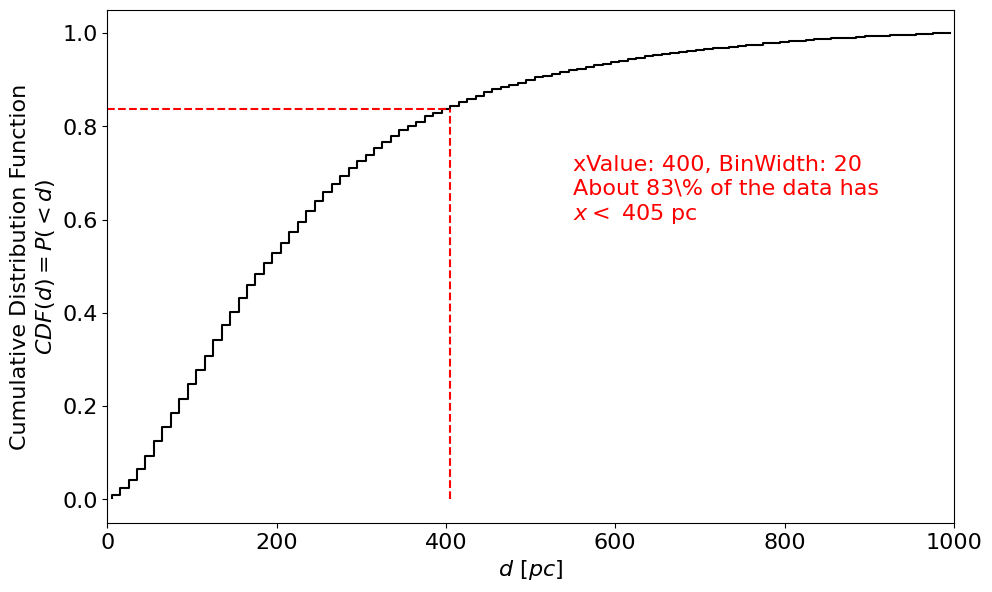

In [98]:
CumSumData = np.cumsum(counts0 / ( len(Data) ))

xValue = 400

BinNumbers = np.where( Bins100 >= xValue )
BinNumber  = BinNumbers[0][0]


fs=16
fig = plt.figure( figsize = ( 10, 6 ) )

plt.step( Bins100, CumSumData, 'k' )

plt.hlines(y=CumSumData[ BinNumber ], xmin=0, xmax=Bins100[ BinNumber ], linestyle='--',color='red')
plt.vlines(x=Bins100[ BinNumber ], ymin=0, ymax=CumSumData[ BinNumber ], linestyle='--',color='red')


plt.xlim( xMin, xMax )
# plt.ylim( 0, 1 )

plt.text( 550, 0.6, 'xValue: ' + str( xValue ) + ', BinWidth: ' + str( int( BinWidth ) ) +\
                    '\nAbout ' + str( int( 100 * CumSumData[ BinNumber ] ) ) +\
                    '\% of the data has\n$x<$ ' + str( int( Bins100[ BinNumber ] ) )+' pc', fontsize = fs ,color='red')

plt.xlabel( '$d~[pc]$', fontsize = fs )
plt.ylabel( 'Cumulative Distribution Function\n' +r'$CDF\left(d\right)=P\left(<d\right)$', fontsize = fs)
plt.xticks( fontsize = fs )
plt.yticks( fontsize = fs )
plt.tight_layout(pad=1)
plt.show()

# Next, let's go over some basic statistics using our hipparcos data. We'll do them the easy way and a manual way:

## Probability Distribution Moments

From a probability distribution we can calculate some characteristic quantities. One such quantity is the *mean*. The mean tells you roughly *where the data is*. We can also calculate the *variance*. The *variance* is the mean of the square of the difference between the variable and the mean and tells you roughly *how spread out the data is*.

**Mean (first moment of the distribution)**: $\mu=\left<d\right>$.

**Variance (second moment of the distribution)**: $\sigma^2=\left<\left(d-\mu\right)^2\right>$. ($\sigma$ is the standard deviation)

**Skewness (third moment)**: $S_3=\frac{1}{N\sigma^3}\sum\limits_i\left(x_i-\mu\right)^3$. -- Tells us how symmetric the distribution is

**Kurtosis (fourth moment)**: $S_4=\frac{1}{N\sigma^4}\sum\limits_i\left(x_i-\mu\right)^4-3$. -- Tells us how the distribution is curved. Pointier than Gaussian is positive Kurtosis

For a Gaussian distribution, all moments higher than 2 are zero

The *mode* of the distribution is the most common value (the peak of the distribution)

The *median* of the distribution is the middle value. i.e. the median is the point where the probability is one half. Also, it is the point in the distribution where the areas under the curves on each side of the median are equal

In [99]:
# Mean
N = len(Data)
manual_mean = sum(Data) / N # manual way
easy_mean = np.nanmean(Data)
print('mean:',manual_mean,easy_mean)
print(' ')

# Median:
d  = np.sort(Data) #temporary variable to avoid sorting our original data variable
if N % 2 == 0:
    median1 = d[N//2]
    median2 = d[N//2 - 1]
    manual_median = (median1 + median2)/2
else:
    manual_median = d[N//2]
    
easy_median  = np.nanmedian(Data)
print('median:', manual_median,easy_median)
print(' ')


# Standard Deviation

manual_var  = sum( (x-manual_mean)**2 for x in Data ) / N  # variance
manual_std  = manual_var**0.5  # standard deviation

easy_std = np.nanstd(Data)
print('Standard Deviation:',manual_std,easy_std)
print(' ')

# Skewness
# is a measure of the asymmetry of a distribution. 
# A distribution is asymmetrical when its left and right side are not mirror images. 
# A distribution can have right (or positive), left (or negative), or zero skewness.
manual_Skewness = sum((Data-manual_mean)**3)/(N*(manual_std**3))
easy_Skewness = stats.skew(Data)
print('Skewness:',manual_Skewness,easy_Skewness)
print(' ')


# Kurtosis
# is a measure of how shallow a distribution (or how narrow its tails) are.
# a low kurtosis means, the tails on both sides of a distrubution are narrow.
# a high kurtosis means, the tails on both sides of a distrubution are wide.
manual_kurtosis = sum((Data-manual_mean)**4)/((N)*(manual_std**4))-3 #Fisher's Kurtosis method
easy_kurtosis = stats.kurtosis(Data)
print('Kurtosis: ',manual_kurtosis,easy_kurtosis)

mean: 247.7753560712139 247.77535607121422
 
median: 196.5 196.5
 
Standard Deviation: 188.69960245271304 188.69960245271267
 
Skewness: 1.4174458318976748 1.4174458318976815
 
Kurtosis:  1.9441497834187516 1.944149783418788


## Percentiles (median et. al.)

#### On the cumulative distribution function, the quantities on the veritcal axis are the *percentiles*. i.e. if you are at 0.7 that is the 70th percentile. That means that 70% of the data lie between $x_{\text{min}}$ and $x$.

In [100]:
# calculating percentiles:

# for the manual way, we'll use a function:

def my_percentile(data, percentile):
    import math
    n = len(data)
    p = n * percentile / 100
    if p.is_integer():
        return sorted(data)[int(p)]
    else:
        return sorted(data)[int(math.ceil(p)) - 1]

    
p = 0.16
manual_percentile=my_percentile(Data, percentile=p)
easy_percentile = np.nanpercentile(Data,p)
print(str(int(p*100))+'th percentile',manual_percentile, easy_percentile) # these are close-ish

p = 0.5 #median
manual_percentile=my_percentile(Data, percentile=p)
easy_percentile = np.nanpercentile(Data,p)
print(str(int(p*100))+'th percentile',manual_percentile, easy_percentile) # these are close-ish


p = 0.84
manual_percentile=my_percentile(Data, percentile=p)
easy_percentile = np.nanpercentile(Data,p)
print(str(int(p*100))+'th percentile',manual_percentile, easy_percentile) # these are close-ish

16th percentile 8.4 8.4716544
50th percentile 14.22 14.26925
84th percentile 19.72 19.934456


# Fitting Data

## For our histogram of hipparcos data, we're going to fit the data assuming it is like a exponential function of the form:

## $y = \sqrt{x}~\times~e^{-\bigg(\frac{x}{x_{[y=y_{max}]}} \bigg)}$ 

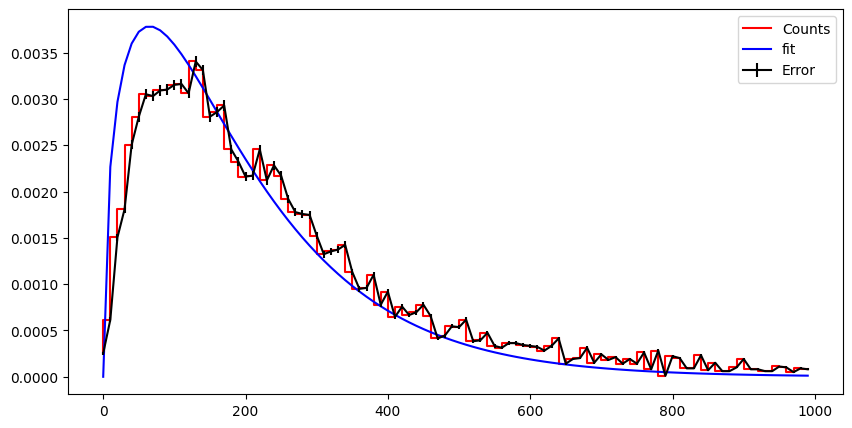

Binned Mean
194.48416445162349
Binned Sigma
154.6293990469359


In [101]:
#Manually creating Bins
bins0 = np.linspace(0,1000,101) #start, stop, stepsize
bins1 = bins0[0:-1]

# normalizing data
counts = counts0/len(Data)

def scaled_exponential(x, mu, sig):
    return mu*np.exp((-1.0*x/sig))

#hand tweaking, this is a better fit when scaling the exponential with 150
# y = scaled_exponential(x=bins1, mu=np.sqrt(bins1), sig=150)

y = scaled_exponential(x=bins1, mu=np.sqrt(bins1), sig=bins1[np.argmax(counts)])

dmax = np.max(bins1); dmin =np.min(bins1); binwidth = float((dmax-dmin)/100)

normalized_y = y/(np.sum(y)*binwidth)

counts_one_hundred = counts/binwidth


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)    # The big subplot
ax.step(bins1, counts_one_hundred, color = 'red', label='Counts')
ax.plot(bins1, normalized_y, color = 'blue', label = 'fit')

errorbars = (counts_one_hundred/(len(counts_one_hundred)*binwidth) )/np.sqrt(counts_one_hundred)
ax.errorbar(bins1, counts_one_hundred, yerr=errorbars, color = 'black', label='Error' )
ax.legend(loc='best')
plt.show()


#Binned Mean
print('Binned Mean')
BinMean= np.sum(normalized_y*bins1*binwidth)
print(BinMean)
n = len(Data)

print('Binned Sigma') 
sigma = np.sqrt(np.sum(((bins1-BinMean)**2)*(normalized_y*binwidth)))
print (sigma)

# Next, let's estimate the binned cumulative probability for our data:

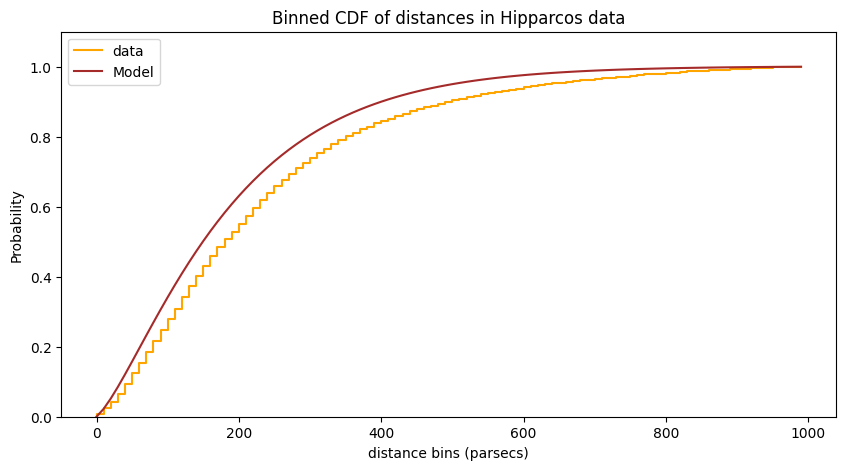

In [102]:
CumSumData = np.cumsum(counts0 / len(Data))
binned_CumSumData = np.cumsum(normalized_y*binwidth)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)    # The big subplot
ax.step(bins1, CumSumData, color = 'orange', label='data')
ax.plot(bins1, binned_CumSumData, color = 'brown', label = 'Model')
plt.title('Binned CDF of distances in Hipparcos data')
plt.xlabel('distance bins (parsecs)'); plt.ylabel('Probability')
plt.legend(loc='best')
plt.ylim(0,1.1)
plt.show()

# So, these aren't perfect fits since our Gaussian is slightly off.

# To estimate the "goodness" of a fit, we can use the $\chi ^2$ test, where

## $\chi ^2$ = $\sum \frac{(y - \mu_y)^2}{\sigma_y}$

and we can also estimate the uncertainty of our model:

# Poisson Error:

## $\sigma=\frac{dP/dx}{\sqrt{N\left(x\right)}}$

ChiSq: 11541.450283641982


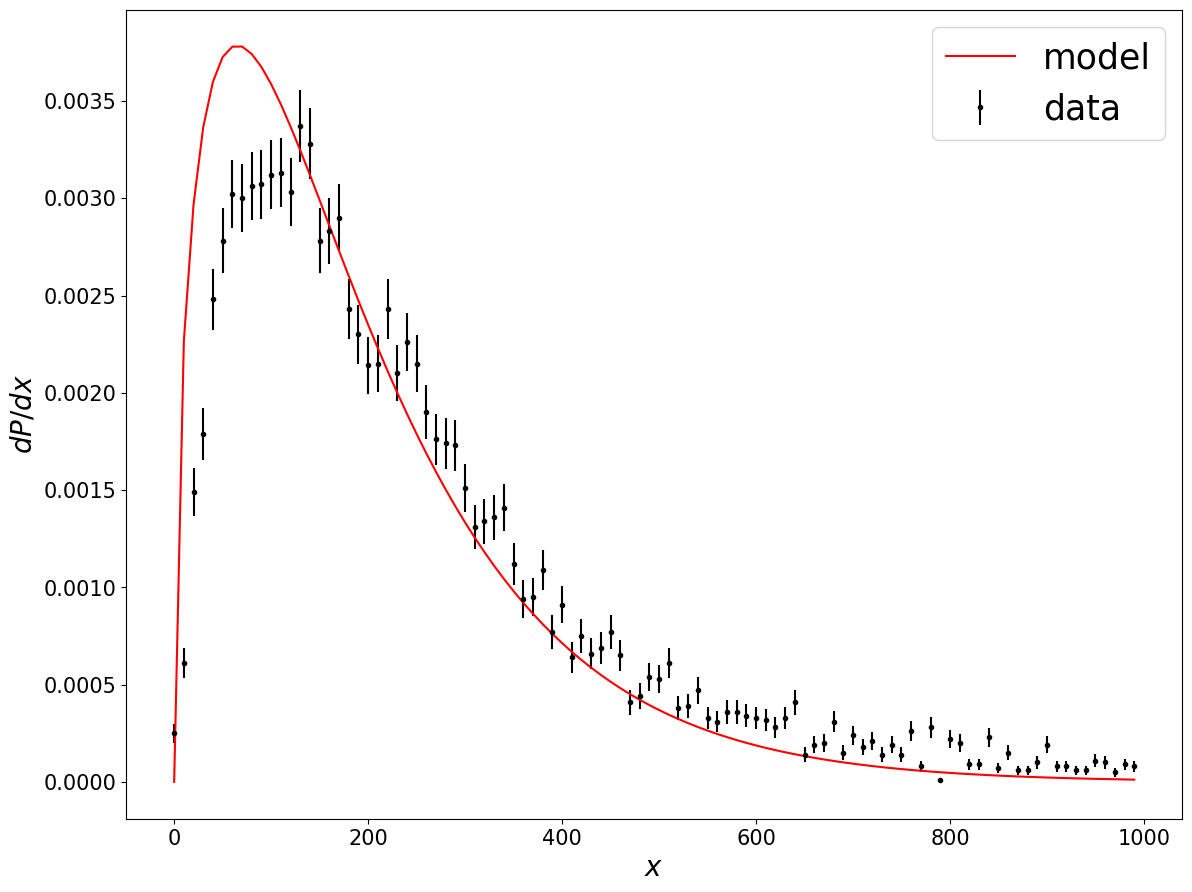

In [103]:
# N(x) is the number of data per bin which is un-normalized and unaccounted for binwidth 
# so we multipy by len(data) * binwidth


SigmaDataPointsPerBin  = (DataPointsPerBinNormalized100)/np.sqrt(DataPointsPerBinNormalized100*len(Data)*BinWidth100)


def ChiSqFinder( Data, Model, Sigma ):
    return np.nansum( ( ( Data - Model ) / Sigma )**2 )

ChiSq = ChiSqFinder( DataPointsPerBinBinWidthNormalized, normalized_y, SigmaDataPointsPerBin )
print ('ChiSq:', ChiSq)

fig = plt.figure( figsize = ( 12, 9 ) )

plt.errorbar( bins1, DataPointsPerBinNormalized100, yerr = SigmaDataPointsPerBin, fmt = 'k.', label = 'data' )
plt.plot( bins1, normalized_y, 'r-', label = 'model' )

plt.xlabel( '$x$', fontsize = 20 )
plt.ylabel( '$dP/dx$', fontsize = 20 )
plt.xticks( fontsize = 15 )
plt.yticks( fontsize = 15 )

plt.legend( prop = { 'size' : 25 } )
plt.tight_layout(pad=1)
plt.show()


def ChiSqFinder( Data, Model, Sigma ):
    return np.nansum( ( ( Data - Model ) / Sigma )**2 )

In [104]:
np.sqrt(counts0[0])

5.0

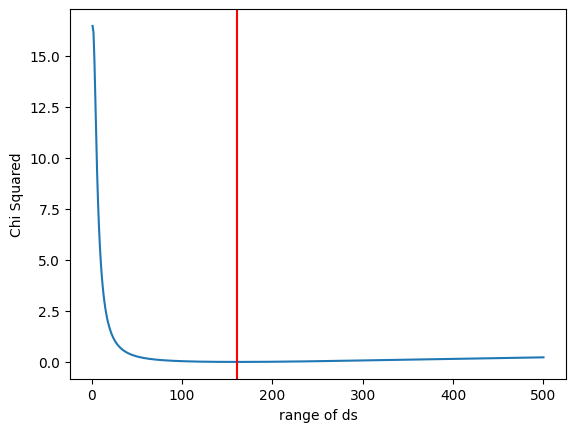

minimum chi squared value: 0.005873558275563695
best ds for fit: 161.0


In [105]:
bins0 = np.linspace(0,1000,101)
bins1 = bins0[0:-1] #100 bins from 0 to 1000
counts0 = np.histogram(Data, bins0)
datalength = len(Data)*1.0
counts = counts0[0]/datalength
counts_one_hundred = counts/binwidth


ds = np.linspace( 1, 500, 500 )#np.linspace(1,1000,2500)

ChiSq = []
for ii in range(0,len(ds)):
    Y = scaled_exponential(x=bins1, mu=np.sqrt(bins1), sig=ds[ii])

    Normalized_Y = Y/(np.sum(Y)*binwidth)
    Sigma = counts_one_hundred/ np.sqrt( counts_one_hundred )
    ChiSq.append(ChiSqFinder( counts_one_hundred, Normalized_Y, Sigma ))

ChiSq = np.array(ChiSq)
ChiSq = ChiSq[~np.isnan(ChiSq)] #removing nan value from first element

plt.plot(ds,ChiSq)
plt.axvline(ds[np.argmin(ChiSq)],color='red')

plt.xlabel('range of ds')
plt.ylabel('Chi Squared')
plt.show()

print ("minimum chi squared value:",np.nanmin(ChiSq))
print ("best ds for fit:",ds[np.argmin(ChiSq)])

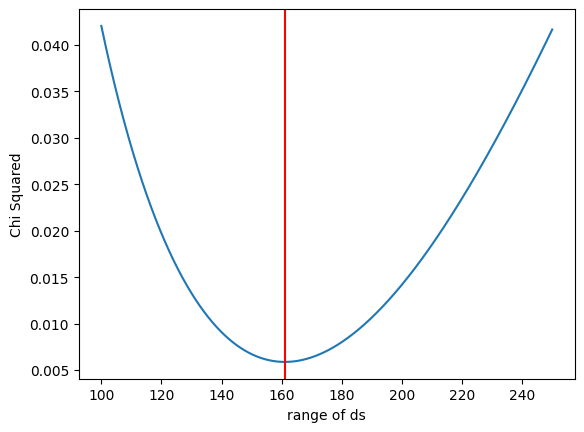

minimum chi squared value: 0.0058735428479230285
best ds for fit: 161.04441776710684


In [106]:
#Let's tackle a better fit for the hipparchos data
#To do this, let's write a for loop that will construct a new fit, Y, and calculate chi sq. for
#each iteration:

ds = np.linspace(100,250,2500)

ChiSq = []
for ii in range(0,len(ds)):
    Y = scaled_exponential(x=bins1, mu=np.sqrt(bins1), sig=ds[ii])
    Normalized_Y = Y/(np.sum(Y)*binwidth)
    Sigma = counts_one_hundred/ np.sqrt( counts_one_hundred )
    ChiSq.append(ChiSqFinder( counts_one_hundred, Normalized_Y, Sigma ))

ChiSq = np.array(ChiSq)
ChiSq = ChiSq[~np.isnan(ChiSq)] #removing nan value from first element

plt.plot(ds,ChiSq)
plt.xlabel('range of ds')
plt.ylabel('Chi Squared')
plt.axvline(ds[np.argmin(ChiSq)],color='red')
# plt.ylim(0,2500)
# plt.xlim(100,250)
plt.show()

print ("minimum chi squared value:",np.min(ChiSq))
print ("best ds for fit:",ds[np.argmin(ChiSq)])

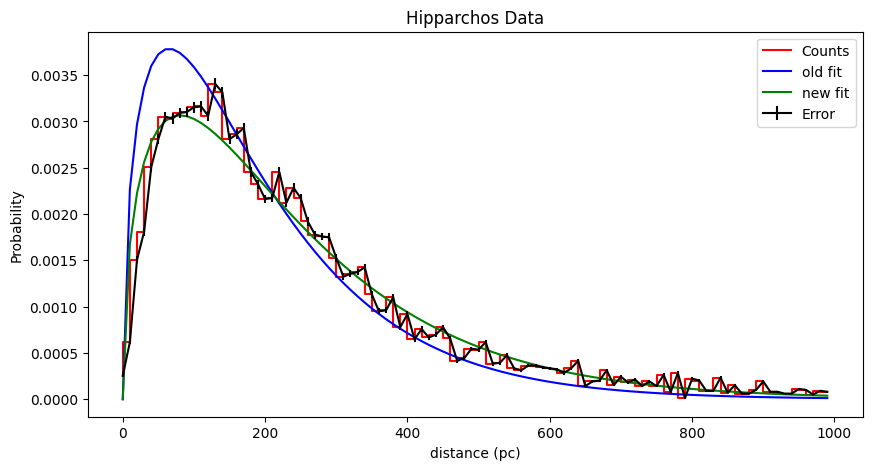

Reduced Chi Squared for Fit 1: 5.932871563558615e-05


In [107]:
ds_min = ds[np.argmin(ChiSq)]
new_Y = np.sqrt(bins1)*np.exp((-1.0*bins1/ds_min))
new_Y = scaled_exponential(x=bins1, mu=np.sqrt(bins1), sig=ds_min)
norm_Y = new_Y/(np.sum(new_Y)*binwidth)
                              
#Try out ds_min in a plot:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)    # The big subplot
ax.step(bins1, counts_one_hundred, color = 'red', label='Counts')
ax.plot(bins1, normalized_y, color = 'blue', label = 'old fit')
ax.plot(bins1,norm_Y, color = 'green', label = 'new fit')
ax.errorbar(bins1, counts_one_hundred, yerr=errorbars, color = 'black', label='Error' )
ax.legend(loc='best')
ax.set_xlabel('distance (pc)')
ax.set_ylabel('Probability')
ax.set_title('Hipparchos Data')
plt.show()

DOF = len(bins1) - 1 #There's only 1 parameter: ds
Reduced_ChiSq = np.min(ChiSq)/ DOF; print( "Reduced Chi Squared for Fit 1:", Reduced_ChiSq)

In [108]:
#Let's change Y again to improve chi squared: Y = (x^p)* e^(-x/ds)
def new_function(x,p,ds):
    Y = (x**p) * np.exp(-x/ds)
    return Y


DS=np.linspace(1,250,500)
P =np.linspace(0,2,500); 
print(len(DS))

ChiSq2 = np.empty((DS.size,P.size)); 

#ChiSq2 = []
for ii in range(len(DS)):
    for jj in range(len(P)):
        Y2 = new_function(x=bins1,p=P[jj],ds=DS[ii])
        Normalized_Y2 = Y2/(np.nansum(Y2)*binwidth)
        # ChiSq2[ii,jj] = (np.nansum( ((counts_one_hundred - Normalized_Y2)**2) / (sigma**2) ) )
        ChiSq2[ii,jj] = ChiSqFinder( counts_one_hundred, Normalized_Y2, Sigma )
        
print ("Minimum Chi Squared value for new model:", np.nanmin(ChiSq2))

500
Minimum Chi Squared value for new model: 0.0034253593384357974


/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_21246/3690546275.py:3: RuntimeWarning: overflow encountered in power
  Y = (x**p) * np.exp(-x/ds)
/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_21246/151041327.py:4: RuntimeWarning: invalid value encountered in divide
  norm_Y2 = new_Y2/(np.sum(new_Y2)*binwidth)


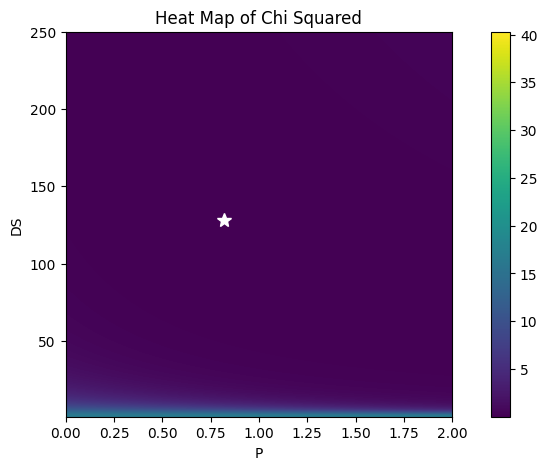

Minimum Chi Squared value for new model: 0.0034253593384357974
best DS value: 128.2444889779559
best P value: 0.8216432865731462


In [109]:
i,j = np.where(ChiSq2==np.nanmin(ChiSq2))

new_Y2 = new_function(x=bins1,p=i,ds=jj)
norm_Y2 = new_Y2/(np.sum(new_Y2)*binwidth)

DS_best =DS[i[0]]; P_best=P[j[0]]


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
im = ax.imshow(ChiSq2,extent=([P[0],P[-1],DS[0],DS[-1]]), aspect=0.008, origin='lower')#, vmin=200, vmax=1000, origin='lower')
fig.colorbar(im)
plt.plot(P_best,DS_best, markersize=10,color='white', marker='*')
plt.xlabel('P')
plt.ylabel('DS')
plt.title('Heat Map of Chi Squared')
plt.show()

print ("Minimum Chi Squared value for new model:", np.min(ChiSq2))
print ("best DS value:", DS_best); print( "best P value:", P_best)


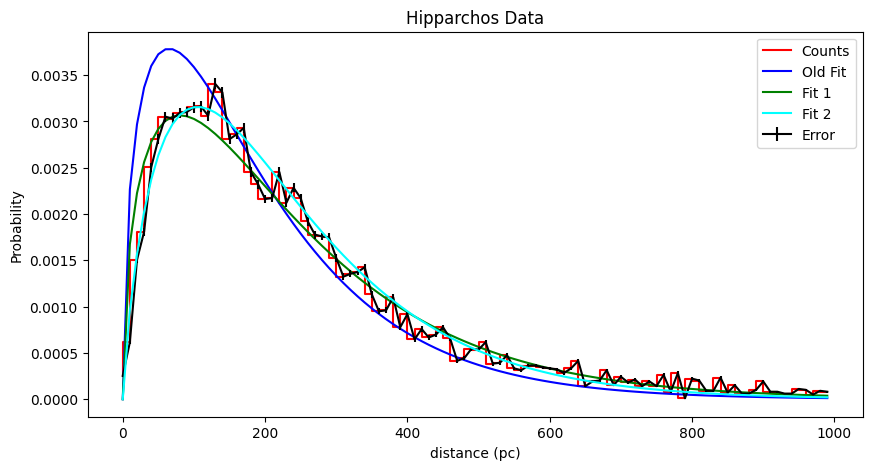

chi squared: 0.013275113831020818
p-value: 1.0
Reduced Chi Squared for Old Fit: 0.00013409205889920018
Reduced Chi Squared for Fit 1: 5.932871563558615e-05
Reduced Chi squared for Fit 2: 3.495264631056936e-05


In [110]:
new_Y2 = new_function(x=bins1,p=P_best,ds=DS_best)
norm_Y2 = new_Y2/(np.sum(new_Y2)*binwidth)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)    # The big subplot

ax.step(bins1, counts_one_hundred, color = 'red', label='Counts')
ax.plot(bins1, normalized_y, color = 'blue', label = 'Old Fit')
ax.plot(bins1,norm_Y, color = 'green', label = 'Fit 1')
ax.plot(bins1,norm_Y2, color = 'cyan', label = 'Fit 2',zorder=10)# zorder places it in the frontmost layer
ax.errorbar(bins1, counts_one_hundred, yerr=errorbars, color = 'black', label='Error' )

ax.legend(loc='best')
ax.set_xlabel('distance (pc)')
ax.set_ylabel('Probability')
ax.set_title('Hipparchos Data')
plt.show()

DOF2 = len(bins1)-2 #2 parameters
dof = len(bins1)-0 #no parameters in old fit

# chisq = np.nansum( ((counts_one_hundred - normalized_y)**2) / (sigma)**2)
chisq = ChiSqFinder( counts_one_hundred, normalized_y, Sigma )
print ("chi squared:", chisq)
P_Value = 1 - stats.chi2.cdf(chisq,len(counts_one_hundred))
print( "p-value:", P_Value )

Reduced_ChiSq0 =np.min(chisq)/ DOF; print ("Reduced Chi Squared for Old Fit:", Reduced_ChiSq0)
Reduced_ChiSq = np.min(ChiSq)/ DOF; print ("Reduced Chi Squared for Fit 1:", Reduced_ChiSq)
Reduced_ChiSq2 = np.min(ChiSq2) / DOF2 ; print( "Reduced Chi squared for Fit 2:", Reduced_ChiSq2)

[[0.34275303 0.93932505 0.9959131  0.76036778 0.35270482]
 [0.24425508 0.0449657  0.48586067 0.11931855 0.88539778]]
0.5170861564103159


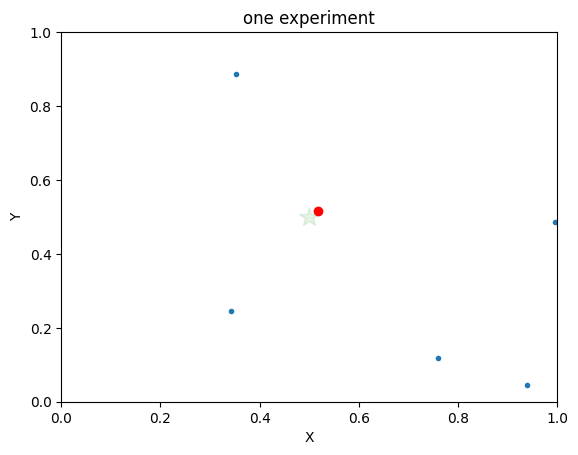

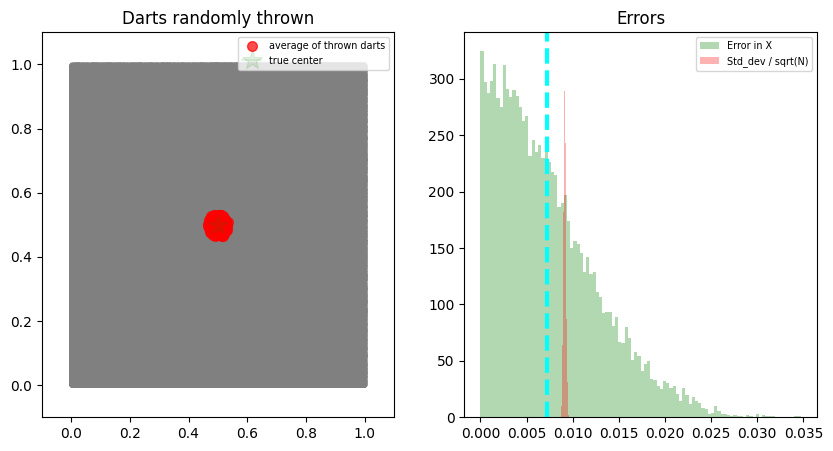

In [111]:
# Dart Throwing Example


#Create 5 random points
#one experiment
r = np.random.rand(2,5); print( r)
mean_r = np.mean(r); print (mean_r)



#Now do this a BUNCH of times (for loop it!)

number = 1000
iterations= 10000
MeanR1 = []; R1 = [];MeanR2 = []; R2 = [];STD_R1= [];STD_R2= []
for ii in range(0,iterations):
    Rand1 = np.random.rand(number)
    Rand2 = np.random.rand(number)
    R_avg1 = np.mean(Rand1)
    R_avg2 = np.mean(Rand2)
    MeanR1.append(R_avg1); #fills average random values to an array
    MeanR2.append(R_avg2);
    R1.append(Rand1)
    R2.append(Rand2)
    R_STD1 = np.std(Rand1,ddof=1) 
    R_STD2 = np.std(Rand2,ddof=1)
    STD_R1.append(R_STD1) #fills std_dev of random values to an array
    STD_R2.append(R_STD2)

R = [R1,R2]
STD_R = [STD_R1,STD_R2]



#Let's plot a histogram of the error
#error in x = mean-center
MeanR1= np.array(MeanR1)
MeanR2= np.array(MeanR2)

center = [np.linspace(0.5,0.5,iterations),np.linspace(0.5,0.5,iterations)]
MeanR = [MeanR1,MeanR2]
Error_X = np.abs(np.subtract(MeanR, center))


STD_over_N_R = np.divide(STD_R , np.sqrt(number))


plt.plot(r[0],r[1], marker='.', linestyle='none')
plt.plot(0.5,0.5,marker='*', markersize=15, color='green', alpha = 0.10, label='true center')
plt.plot(mean_r,mean_r,marker='o', color='red')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('one experiment')
plt.show()

Mean_of_Error_X = np.mean(Error_X[0])

fig = plt.figure(figsize=(10,5))

bx = fig.add_subplot(121)
bx.plot(R1,R2, marker='.', linestyle='none', color='grey',markersize=3,alpha=0.3)
bx.plot(MeanR1, MeanR2, marker='o', color='red',linestyle='none', markersize = 7,alpha=0.7, label='average of thrown darts' )
bx.plot(0.5,0.5,marker='*', markersize=15, color='green', alpha = 0.10, label='true center')
bx.set_xlim(-0.1,1.1)
bx.set_ylim(-0.1,1.1)
bx.set_title("Darts randomly thrown")
bx.legend(loc='upper right',fontsize = 'x-small')

ax = fig.add_subplot(122)    # The big subplot
ax.hist(Error_X[0], bins=100, label='Error in X', alpha=0.3, color='green')
# ax.hist(STD_R[0], bins=100, label='Std_dev', alpha=0.3, color='blue')
ax.hist(STD_over_N_R[0], bins=100, label='Std_dev / sqrt(N)', alpha=0.3, color='red')
ax.axvline(x=Mean_of_Error_X, color='cyan', linewidth=3, linestyle='--')
ax.set_title("Errors")
ax.legend(loc='upper right',fontsize = 'x-small')

plt.show()

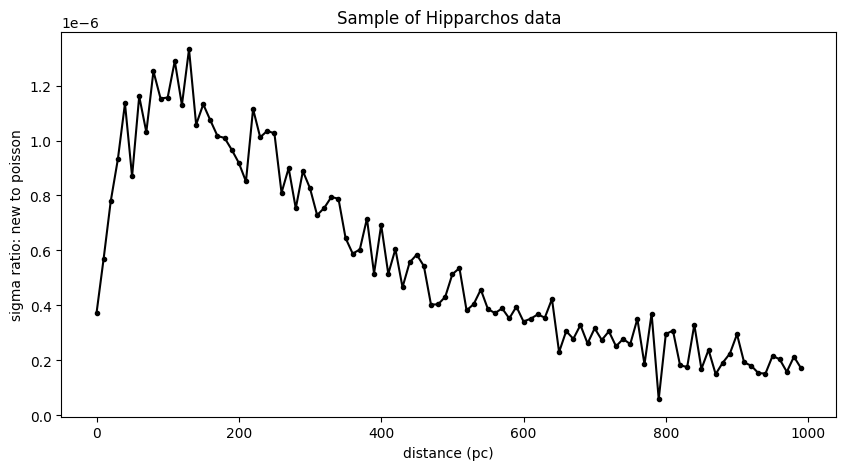

In [112]:
#------------------------------------Bootstrap sampling-----------------------------------------------------

# 1st decide how big sample of data will be, use np.random.choice(data, samplesize)

iterations = 100
samplesize = 10000
Nbins = len(bins1)

datalength = len(Data)
bin_sample = np.linspace(0,1000,101)
bins = bin_sample[0:-1]
dmax_sample = np.max(bins); dmin_sample =np.min(bins)
binwidth_sample = float(dmax_sample-dmin_sample)/Nbins

sample = [] ; SCounts0 = np.empty((iterations,Nbins)); sample = np.empty((iterations,Nbins))
#sampling the data
for ii in range(0,Nbins):
    samp = np.random.choice(Data,samplesize)
    sample_counts0 = np.histogram(samp, bin_sample)
    SCounts0[ii,:] = sample_counts0[0]/float(datalength)/binwidth_sample
    sample[ii,:] = sample_counts0[0]


new_sigma = np.std(SCounts0, axis=0) #error in sample

sigma_ratio = new_sigma/sigma #new error over original hipparcos error 

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)    # The big subplot
ax.plot(bins, sigma_ratio, color='black', marker = '.')
ax.set_title('Sample of Hipparchos data')
ax.set_xlabel('distance (pc)')
ax.set_ylabel('sigma ratio: new to poisson')
plt.show()

In [113]:
data = np.loadtxt('hipparcos_subsample.dat')
data_range = np.arange(0,9998)

bins0 = np.linspace(0,1000,101)
bins1 = bins0[0:-1] #100 bins from 0 to 1000

bins_tenthousand0 = np.linspace(0,1000, 10001)
bins_tenthousand = bins_tenthousand0[0:-1] #10,000 bins from 0 to 1000

counts0 = np.histogram(data, bins0)
datalength = len(data)*1.0 #100
counts = counts0[0]/datalength
dmax = np.max(bins1); dmin =np.min(bins1)
binwidth = float(dmax-dmin)/len(bins1)

dmax_tenthou = np.max(bins_tenthousand); dmin_tenthou =np.min(bins_tenthousand)
binwidth_tenthou = float(dmax_tenthou-dmin_tenthou)/len(bins_tenthousand)

N_tot = float(len(counts)) #10,000 stars

dPddist = counts/N_tot/binwidth
counts0 = np.histogram(data, bins0)
datalength = len(data)*1.0
counts = counts0[0]/datalength
counts_one_hundred = counts/binwidth

sigma = np.sqrt(counts)/N_tot/binwidth ; #sigma for 100 bins, 10,000 stars


y = scaled_exponential(x=bins1, mu=np.sqrt(bins1), sig=150)
normalized_y2 = y/(np.sum(y)*binwidth)

y_tenthou = scaled_exponential(x=bins_tenthousand, mu=np.sqrt(bins_tenthousand), sig=150)
normalized_y_tenthou = y_tenthou/(np.sum(y_tenthou)*binwidth_tenthou)


chisq = np.sum(((counts_one_hundred - normalized_y2)/sigma)**2) ; print( "chi squared:", chisq)
chisq = ChiSqFinder( counts_one_hundred, normalized_y2, sigma )
P_Value = 1 - stats.chi2.cdf(chisq,100); print ("p-value:", P_Value )

ds = np.linspace(1,1000,2500) # a range of values to test first model with

ChiSq = []
for ii in range(0,len(ds)):
    Y = scaled_exponential(x=bins1, mu=np.sqrt(bins1), sig=ds[ii])
    Normalized_Y = Y/(np.sum(Y)*binwidth)
    # ChiSq.append(np.sum(((counts_one_hundred - Normalized_Y)/sigma)**2))
    ChiSq.append(ChiSqFinder( counts_one_hundred, Normalized_Y, sigma ))

ChiSq = np.array(ChiSq) #An array of chi squared values created to see which is the smallest (aka the best)
ChiSq = ChiSq[~np.isnan(ChiSq)] #removing nan value from first element


ds = ds[0:-1]

ds_min = ds[np.argmin(ChiSq)]
new_Y = np.sqrt(bins1)*np.exp((-1.0*bins1/ds_min))
norm_Ya = new_Y/(np.sum(new_Y)*binwidth)

#Let's try two parameters DS and P in a 2nd model

DS=np.linspace(1,250,500)
P =np.linspace(0,2,500); 

ChiSq2 = np.empty((DS.size,P.size))  #empty array with the dimensions of [DS,P]

for ii in range(len(DS)):
    for jj in range(len(P)):
        Y2 = new_function(x=bins1,p=P[jj],ds=DS[ii])
        Normalized_Y2 = Y2/(np.sum(Y2)*binwidth)
        # ChiSq2[ii,jj] = (np.sum( ((counts_one_hundred - Normalized_Y2)**2) / (sigma**2)) ) #creating a range of chi squares to test
        ChiSq2[ii,jj] = ChiSqFinder( counts_one_hundred, Normalized_Y2, sigma )
        
i,j = np.where(ChiSq2==np.min(ChiSq2)) #indices where smallest (aka best) chi squared occurs
DS_best =DS[i[0]]; P_best=P[j[0]]

bins1_shift = bins1+0.5*binwidth #to avoid zeros in first bin, shift the bin by a half binwidth

new_Y2 = new_function(x=bins1_shift,p=P_best,ds=DS_best)
norm_Y2a = new_Y2/(np.sum(new_Y2)*binwidth)



DOF = len(bins1) - 1 #1 parameter: ds
DOF2 = len(bins1)-2 #2 parameters
Reduced_ChiSq0 =np.min(chisq)/ DOF; print ("Reduced Chi Squared for Old Fit:", Reduced_ChiSq0)
Reduced_ChiSq = np.min(ChiSq)/ DOF; print ("Reduced Chi Squared for Fit 1:", Reduced_ChiSq)
Reduced_ChiSq2 = np.min(ChiSq2) / DOF2 ; print ("Reduced Chi squared for Fit 2:", Reduced_ChiSq2)


chi squared: 664.2701566285181
p-value: 0.0
Reduced Chi Squared for Old Fit: 6.709799561904223
Reduced Chi Squared for Fit 1: 5.873679203754615
Reduced Chi squared for Fit 2: 3.4603119847463675


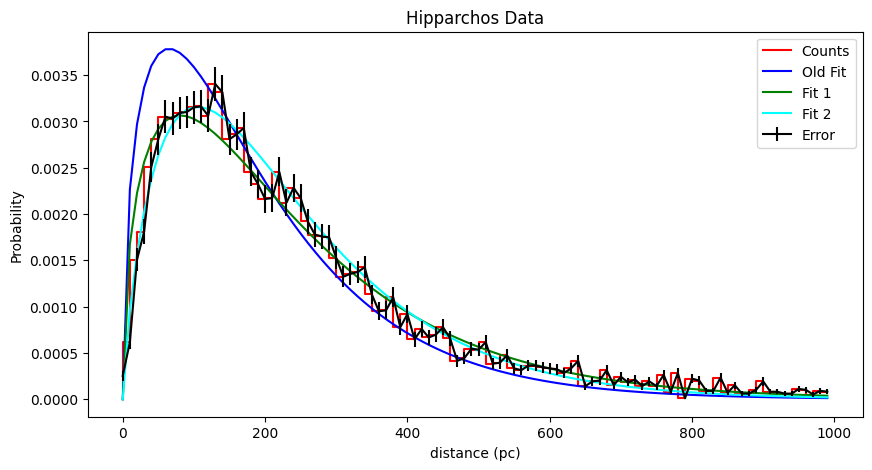

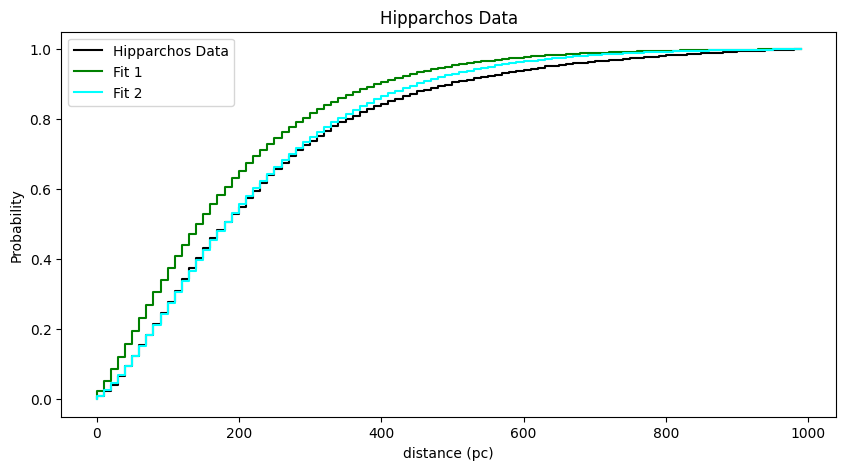

In [114]:
#-------------------------------------Making A Fake Hipparchos Data set-------------------------------------

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)    # The big subplot
ax.step(bins1, counts_one_hundred, color = 'red', label='Counts')
ax.plot(bins1, normalized_y, color = 'blue', label = 'Old Fit')
ax.plot(bins1,norm_Y, color = 'green', label = 'Fit 1')
ax.plot(bins1,norm_Y2, color = 'cyan', label = 'Fit 2')
ax.errorbar(bins1, counts_one_hundred, yerr=sigma, color = 'black', label='Error' )
ax.legend(loc='best')
ax.set_xlabel('distance (pc)')
ax.set_ylabel('Probability')
ax.set_title('Hipparchos Data')
plt.show()


#Convert model (Y2) to cumuluative probability(np.cumsum(counts))
CumulSum = np.cumsum(counts)
CumulSum2 = np.cumsum(norm_Y2*binwidth)
CumulSum1 = np.cumsum(normalized_y*binwidth)
CumulSum_tentho = np.cumsum(normalized_y_tenthou*binwidth_tenthou)

#Cumulative Probabilities plot for original data, 1st and 2nd models
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)    # The big subplot
ax.step(bins1, CumulSum, color = 'black', label = 'Hipparchos Data', linewidth=1.5)
ax.step(bins1,CumulSum1, color = 'green', label = 'Fit 1')
ax.step(bins1,CumulSum2, color = 'cyan', label = 'Fit 2')
ax.legend(loc='best')
ax.set_xlabel('distance (pc)')
ax.set_ylabel('Probability')
ax.set_title('Hipparchos Data')
plt.show()



/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_21246/4149263636.py:30: RuntimeWarning: invalid value encountered in divide
  sigma3 = fakecounts/np.sqrt(fake_counts0[0])


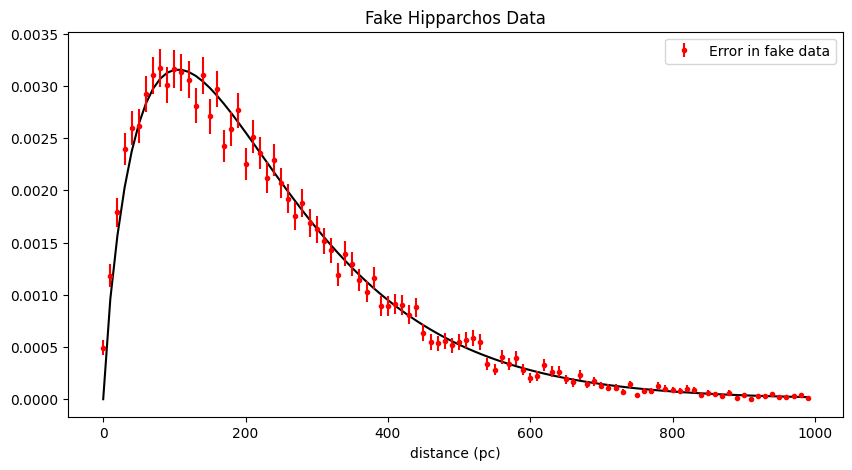

Chi Squared for fake data: 158.6349314819168
Reduced Chi Squared for fake data: 1.6023730452718867


In [115]:
fake_data = np.random.uniform(0,1,10000) #create random 10,000 points

bins_tenthousand = np.linspace(0,1000, 10000) #10,000 bins


bins_tenthousand_binwidth = (np.max(bins_tenthousand)-np.min(bins_tenthousand))/len(bins_tenthousand)
bins_tenthousand_center = bins_tenthousand+bins_tenthousand_binwidth #bins shifted by half a bin width

y_tenthou = new_function(x=bins_tenthousand,p=P_best,ds=DS_best)
normalized_y_tenthou = y_tenthou/(np.sum(y_tenthou)*bins_tenthousand_binwidth) # used for more detailed results

CumulSum_tentho = np.cumsum(normalized_y_tenthou*bins_tenthousand_binwidth) #cumulative probability of 10,000 binned
#                                                                            2nd model

Pcum = CumulSum_tentho

dmodel = bins_tenthousand
drandom = dmodel[np.searchsorted(Pcum,fake_data)]

fake_counts0 = np.histogram(drandom,bins0)
fake_datalength = len(drandom)*1.0
fake_counts = fake_counts0[0]/fake_datalength

fake_binwidth = float(dmax-dmin)/len(bins1)

fakecounts = fake_counts/fake_binwidth

N_tot3 = float(len(drandom))

sigma3 = fakecounts/np.sqrt(fake_counts0[0])


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111) 
ax.plot(bins1,norm_Y2, color='black')
ax.errorbar(bins1, fakecounts, yerr=sigma3, color = 'red', label='Error in fake data', fmt='.' )
ax.set_title('Fake Hipparchos Data')
ax.set_xlabel('distance (pc)')
ax.legend(loc='upper right')
plt.show()


diff = (fakecounts-norm_Y2); 
ChiSq3 = np.nansum((diff/sigma3)**2)
ChiSq3 = np.nansum( ((fakecounts-norm_Y2)**2 ) / (sigma3**2) )


print ("Chi Squared for fake data:", ChiSq3)
DOF3 = len(bins1) -1 #1 parameters: ds
print ("Reduced Chi Squared for fake data:", ChiSq3/DOF3)


In [116]:

#Let's make a heat map like earlier

ds_new=np.linspace(1,250,500)
p_new =np.linspace(0,2,500); 


ChiSq_new = np.empty((ds_new.size,p_new.size)); 


for ii in range(len(ds_new)):
    for jj in range(len(p_new)):
        y_new = new_function(x=bins1,p=p_new[jj],ds=ds_new[ii])
        norm_y_new = y_new/(np.sum(y_new)*binwidth)
        # ChiSq_new[ii,jj] = np.nansum( ((fakecounts - norm_y_new)**2)/(sigma**2) ) 
        ChiSq_new[ii,jj] = ChiSqFinder( fakecounts, norm_y_new, sigma )
        
print ("Minimum Chi Squared value for new model:", np.min(ChiSq_new))


Minimum Chi Squared value for new model: 169.61364537410313


/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_21246/3690546275.py:3: RuntimeWarning: overflow encountered in power
  Y = (x**p) * np.exp(-x/ds)
/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_21246/1691306951.py:4: RuntimeWarning: invalid value encountered in divide
  NORM_Y_NEW = Y_NEW/(np.sum(Y_NEW)*binwidth)


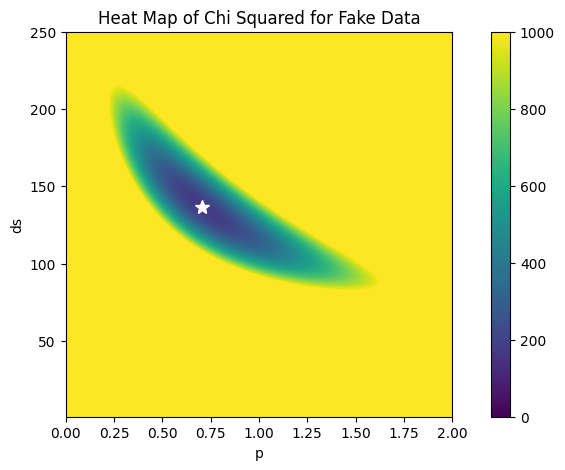

Minimum Chi Squared value for new model: 169.61364537410313
best DS value: 136.72745490981964
best P value: 0.7054108216432865


In [117]:
I,J = np.where(ChiSq_new==np.min(ChiSq_new))

Y_NEW = new_function(x=bins1,p=I,ds=J)
NORM_Y_NEW = Y_NEW/(np.sum(Y_NEW)*binwidth)

ds_best =ds_new[I[0]]; p_best=p_new[J[0]]


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
im = ax.imshow(ChiSq_new, extent=([p_new[0],p_new[-1],ds_new[0],ds_new[-1]]), 
               aspect=0.008, vmin=0, vmax=1000, origin='lower')
fig.colorbar(im)
plt.plot(p_best,ds_best, markersize=10,color='white', marker='*')
plt.xlabel('p')
plt.ylabel('ds')
plt.title('Heat Map of Chi Squared for Fake Data')
plt.show()


print ("Minimum Chi Squared value for new model:", np.min(ChiSq_new))
print ("best DS value:", ds_best)
print ("best P value:", p_best)


In [118]:
#--------------------------------------MCMC Algorithm----------------------------------------------------------------------------
#Let's use a one chain algorithm (Metropolis Hastings)

Nchain = 10000 #length of chain
A = np.empty(Nchain)
DS_mcmc = np.empty(Nchain)
P_mcmc = np.empty(Nchain)
ChiSq_mcmc = np.empty(Nchain)

P_mcmc[0] = 0.5
DS_mcmc[0] = 150

def get_chi2( p, ds, Bins, normalizedcounts, histogrammed_data ):
    y = new_function(x=Bins,p=p,ds=float(ds))
    d_max = np.max(Bins)
    d_min =np.min(Bins)
    bin_width = float(d_max-d_min)/len(Bins)
    norm_y= y/(np.sum(y)*bin_width)
    sigma = normalizedcounts/np.sqrt(histogrammed_data[0])
    # chi2 = np.nansum( ((normalizedcounts - norm_y)**2) /(sigma**2 ) )
    chi2 = ChiSqFinder( normalizedcounts, norm_y, sigma )

    return chi2
    

ChiSq_mcmc[0] = get_chi2( P_mcmc[0], DS_mcmc[0], bins1, fakecounts, fake_counts0)

for ii in range(1,Nchain):
    P_step = np.random.normal(loc=0,scale=0.1) #arguments (mean, sigma)
    DS_step= np.random.normal(loc=0,scale=10)

    DS_try = DS_mcmc[ii-1] + DS_step
    P_try = P_mcmc[ii-1] + P_step
    ChiSq_try = get_chi2(P_try, DS_try, bins1, fakecounts, fake_counts0)
    if ChiSq_try < ChiSq_mcmc[ii-1]:
        DS_mcmc[ii] = DS_try
        P_mcmc[ii] = P_try
        ChiSq_mcmc[ii] = ChiSq_try 
    else:
        R = np.random.uniform(0,1)
        if R < (np.exp((ChiSq_mcmc[ii-1]**2-ChiSq_try**2)/2.0)):
            DS_mcmc[ii] = DS_try
            P_mcmc[ii] = P_try
            ChiSq_mcmc[ii] = ChiSq_try 
        else:
            DS_mcmc[ii] = DS_mcmc[ii-1]
            P_mcmc[ii] = P_mcmc[ii-1]
            ChiSq_mcmc[ii] = ChiSq_mcmc[ii-1]


/var/folders/qb/9tctyb8566b3ws5ypfbmqq8r0000gn/T/ipykernel_21246/1579392619.py:19: RuntimeWarning: invalid value encountered in divide
  sigma = normalizedcounts/np.sqrt(histogrammed_data[0])


Chisq_mcmc: [266.71333065 266.71333065 266.71333065 ... 142.47036854 142.47036854
 142.47036854]
Chisq_mcmc minimum: 142.47036854113554

Average of P_mcmc: 0.7413863976591916
best fit P: 0.8216432865731462

Average of DS_mcmc: 131.64713714999178
best fit DS: 128.2444889779559


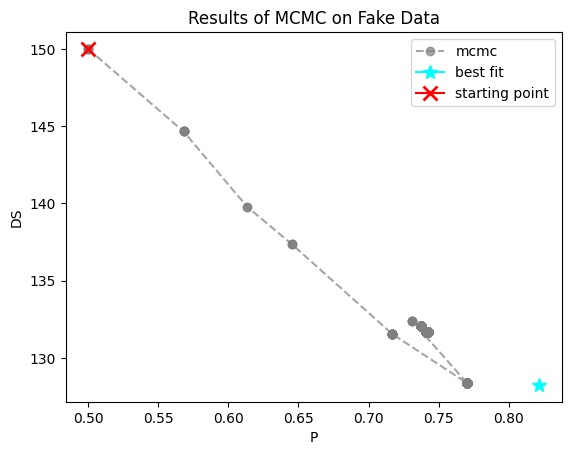

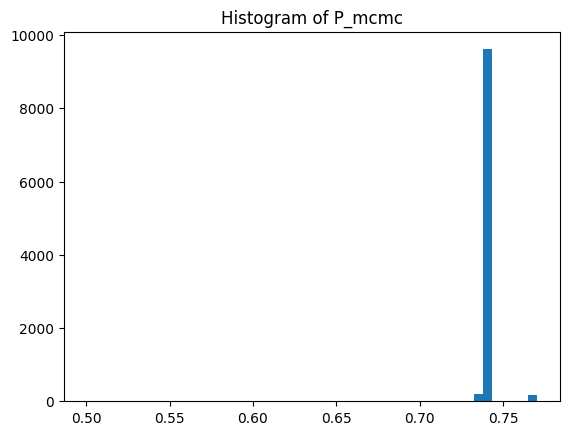

In [119]:
print ("Chisq_mcmc:", ChiSq_mcmc    )

print ("Chisq_mcmc minimum:", np.min(ChiSq_mcmc))
print("")
print ("Average of P_mcmc:", np.mean(P_mcmc))
print ("best fit P:", P_best)
print("")
print ("Average of DS_mcmc:", np.mean(DS_mcmc))
print ("best fit DS:", DS_best)

plt.plot(P_mcmc,DS_mcmc, marker='o', linestyle='--', label='mcmc',alpha=0.7, color='grey' )
plt.plot(P_best,DS_best, marker = "*", color='cyan', markersize=10, label='best fit')
plt.plot(0.5,150,marker = "x", color='red',linestyle='-' ,markersize=10, label='starting point', mew=2)
plt.xlabel('P')
plt.ylabel('DS')
plt.title('Results of MCMC on Fake Data')
plt.legend(loc='best')
plt.show()

plt.hist(P_mcmc,bins=50)
plt.title('Histogram of P_mcmc')
plt.show()


# Let's plot our final fit from our basic MCMC analysis:

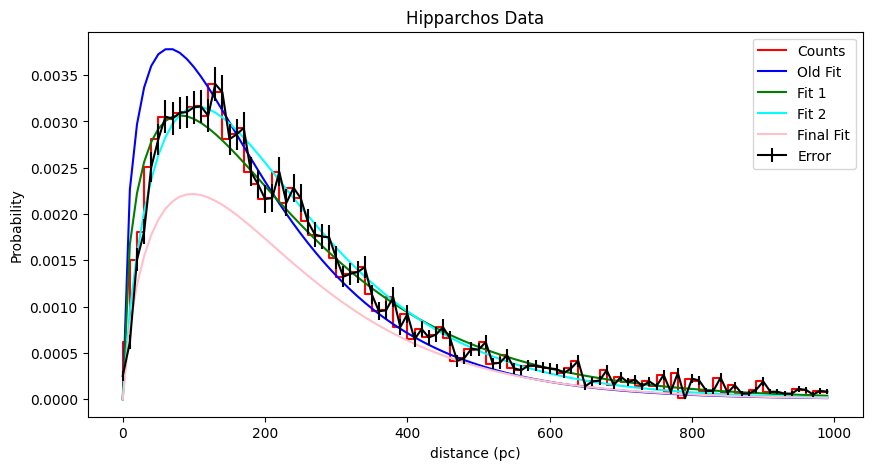

In [120]:
ds_mean = DS_mcmc[np.argmin(ChiSq_mcmc)]
p_mean = P_mcmc[np.argmin(ChiSq_mcmc)]

new_Y3 = new_function(x=bins1,p=p_mean,ds=ds_mean)
norm_Y3 = new_Y3/(np.sum(new_Y2)*binwidth)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)    # The big subplot
ax.step(bins1, counts_one_hundred, color = 'red', label='Counts')
ax.plot(bins1, normalized_y, color = 'blue', label = 'Old Fit')
ax.plot(bins1,norm_Y, color = 'green', label = 'Fit 1')
ax.plot(bins1,norm_Y2, color = 'cyan', label = 'Fit 2')
ax.plot(bins1,norm_Y3, color = 'pink', label = 'Final Fit')
ax.errorbar(bins1, counts_one_hundred, yerr=sigma, color = 'black', label='Error' )
ax.legend(loc='best')
ax.set_xlabel('distance (pc)')
ax.set_ylabel('Probability')
ax.set_title('Hipparchos Data')
#ax.set_axis_bgcolor('black') #color the background
plt.show()

# In the end, our basic MCMC analysis produced a WORSE fit than our for loop chi-square minimization approach. Ideally, with MCMC, you would do tens or hundreds of thousands of chains. Our basic approach, will inefficiently sample our data. There are far better tools for this kind of analysis. 

## See [https://emcee.readthedocs.io/en/stable/](emcee) and [https://docs.pymc.io/en/v3/index.html](PyMC3) for more tutorials and advanced usage. 




In [121]:
print('Best-fit results for our chi-square minimization for loop:')
print ("Minimum Chi Squared value for new model:", np.min(ChiSq_new))
print ("best DS value:", ds_best)
print ("best P value:", p_best)
print('')

print('Best-fit results from our MCMC analysis:')
print ("Minimum Chi Squared value for new model:", np.min(ChiSq_mcmc))
print ("best DS value:", ds_mean)
print ("best P value:", p_mean)

Best-fit results for our chi-square minimization for loop:
Minimum Chi Squared value for new model: 169.61364537410313
best DS value: 136.72745490981964
best P value: 0.7054108216432865

Best-fit results from our MCMC analysis:
Minimum Chi Squared value for new model: 142.47036854113554
best DS value: 131.6736976720737
best P value: 0.7410693978849271


### This notebook was made with the help of Dr. [Andreas Berlind](https://www.nsf.gov/staff/staff_bio.jsp?lan=aberlind&org=NSF&from_org=) and [Sam Dunham](https://www.samueljdunham.com/)